In [391]:
import ee
import rasterio
import numpy as np
from pprint import pprint
from IPython.display import display
from IPython.display import Image
import matplotlib.pyplot as plt
from matplotlib import colors

In [392]:
ee.Initialize()

In [393]:
dataset_path = 'LANDSAT/LC08/C01/T1_TOA'
#path, row = [3, 69] # RMDD
path, row = [25, 38] # TX/LA border
start_date = '2016-01-01'
end_date = '2017-01-01'

collection = ee.ImageCollection(dataset_path) \
    .filter(ee.Filter.eq('WRS_PATH', path)) \
    .filter(ee.Filter.eq('WRS_ROW', row)) \
    .filterDate(start_date, end_date)

In [394]:
cloud_thresh = ee.Number(25.0)
filtered = collection.filterMetadata('CLOUD_COVER', 'less_than', cloud_thresh)

In [395]:
vis_params = {'bands' : 'B5, B6, B4'} # XXX: bands should be a string, not list...

In [396]:
img = ee.Image(filtered.sort('CLOUD_COVER').first())
print(img.bandNames().getInfo())
url = img.getThumbUrl(vis_params)

[u'B1', u'B2', u'B3', u'B4', u'B5', u'B6', u'B7', u'B8', u'B9', u'B10', u'B11', u'BQA']


In [397]:
Image(url=url)

In [398]:
bands = ['B5', 'B6', 'B4']
water = ee.ImageCollection('JRC/GSW1_0/MonthlyHistory')
cur = ee.Image(water.toList(100).get(20))
clipped = cur.clip(img.geometry())
stacked = img.select(bands).addBands(clipped)
bands = stacked.bandNames().getInfo()

In [399]:
print(bands)

[u'B5', u'B6', u'B4', u'water']


In [400]:
training = stacked.sample(numPixels=10000, seed=0).filter(ee.Filter.neq('water', 0)).select(bands)
validation = stacked.sample(numPixels=10000, seed=1).filter(ee.Filter.neq('water', 0)).select(bands)

In [401]:
classifier = ee.Classifier.svm().train(training, 'water')

In [402]:
#bands.remove('water')
classified = stacked.classify(classifier, 'classification')

In [403]:
validated = validation.classify(classifier, 'classification')
accuracy = validated.errorMatrix('water', 'classification')
print(accuracy.accuracy().getInfo())

0.994461281221


In [404]:
vis_params = {'bands' : 'classification'}
url = classified.getDownloadUrl()

In [406]:
filename = download_tiff(clipped, scale=200)

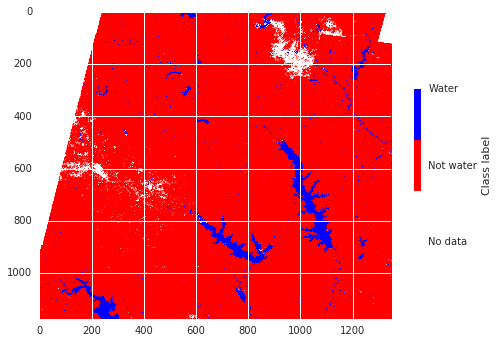

In [ ]:
cmap = colors.ListedColormap(['white', 'red', 'blue'])
bounds = [0, 0.5, 1.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)
with rasterio.open(filename) as r:
    results = r.read(1)
#print(results.shape)
#results = np.stack([results[4], results[3], results[2]], axis=-1)
#print(results.shape)
im = plt.imshow(results, cmap=cmap, norm=norm)
cb = plt.colorbar(im, shrink=0.5, label='Class label', ticks=[0, 1, 2])
cb.ax.set_yticklabels(['No data', 'Not water', 'Water']);

In [ ]:
filename = download_tiff(classified.clip(img.geometry()), scale=200)

In [ ]:
cmap = colors.ListedColormap(['red', 'blue'])
bounds = [1, 1.5, 2]
norm = colors.BoundaryNorm(bounds, cmap.N)
with rasterio.open(filename) as r:
    results = r.read(1)
#print(results.shape)
#results = np.stack([results[4], results[3], results[2]], axis=-1)
#print(results.shape)
im = plt.imshow(results, cmap=cmap, norm=norm)
cb = plt.colorbar(im, shrink=0.5, label='Class label', ticks=[1, 2])
cb.ax.set_yticklabels(['Not water', 'Water']);

In [ ]:
omission = clipped.eq(ee.Number(2)).And(classified.neq(ee.Number(2))).multiply(ee.Number(-1))
comission = clipped.neq(ee.Number(2)).And(classified.eq(ee.Number(2)))
error = omission.add(comission)
filename = download_tiff(error, scale=240)

In [ ]:
with rasterio.open(filename) as r:
    err = r.read(1)
im = plt.imshow(err, cmap='RdBu_r', vmin=-1, vmax=1) #, cmap=cmap, norm=norm)
cb = plt.colorbar(im, shrink=0.5, ticks=[-1, 0, 1])
cb.ax.set_yticklabels(['Omission', '', 'Comission']);